In [123]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
def loadDataSet(fileName):
    dataMat = []
    with open(fileName) as fr:
        for line in fr.readlines():
            currentLine  = line.strip().split('\t')
            fltLine = map(float,currentLine)
            dataMat.append(list(fltLine))
    return np.mat(dataMat)

In [20]:
def binSplitDataSet(dataSet,feature,value):
    mat0 = dataSet[np.nonzero(dataSet[:,feature]>value)[0],:] # np.nonzero 对True False 矩阵寻找True值的索引，[0] 取出行索引
    mat1 = dataSet[np.nonzero(dataSet[:,feature]<=value)[0],:]
    return mat0,mat1

In [21]:
testMat = np.mat(np.eye(4))
testMat

matrix([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]])

In [25]:
binSplitDataSet(testMat,1,0.5)

(matrix([[ 0.,  1.,  0.,  0.]]), matrix([[ 1.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  1.]]))

## 回归树

In [266]:
## 回归树：

# 叶子节点构建方式
# 回归树：叶子节点是一个常数，整体上由常数构成一个分段函数
def regLeaf(dataSet):
    return np.mean(dataSet[:,-1])

# 对连续值数据集判断数据混乱程度
# 数据集本身特性，所以用数据集本身就可以了
def regErr(dataSet):
    return np.var(dataSet[:,-1])*np.shape(dataSet)[0] # 计算总方差 = 均方差 * 样本个数

## 模型树

In [267]:
## 模型树：
# 叶子节点是线性函数，整个树就是一个分段线性函数，每段内数据是线性的
def linearSolve(dataSet):
    m,n = np.shape(dataSet)
    X = np.mat(np.ones((m,n)))
    Y = np.mat(np.ones((m,1)))
    X[:,1:n] = dataSet[:,0:n-1]
    Y = dataSet[:,-1]
    xTx = X.T * X
    if np.linalg.det(xTx) == 0.0:
        print('逆矩阵不存在')
    ws = xTx.I*(X.T*Y)
    return ws,X,Y


# 对于模型而言，其实就是其ws
def modelLeaf(dataSet):
    ws,X,Y = linearSolve(dataSet)
    return ws

def modelErr(dataSet):
    ws,X,Y = linearSolve(dataSet)
    yHat = X*ws
    return np.sum(np.power(Y - yHat,2))

In [323]:
def chooseBestSplit(dataSet,leafType,errType,opt):
    tolS = opt[0] # 两个预剪枝条件，误差大小控制
    tolN = opt[1] # 子节点数据量控制
    if len(set(dataSet[:,-1].T.tolist()[0])) == 1:
#         print("数据类型相同")
        return None,leafType(dataSet)# 叶子节点来源1 # 数据等值
    m,n = np.shape(dataSet)
    S = errType(dataSet)
    bestS = np.inf
    bestIndex = 0
    bestValue = 0
    for featIndex in range(n-1): # 这个地方要减去最后一列的label值
        for splitVal in set(dataSet[:,featIndex].T.tolist()[0]):
            mat0, mat1 = binSplitDataSet(dataSet,featIndex,splitVal)
            if np.shape(mat0)[0] < tolN or np.shape(mat1)[0] < tolN:
#                 print('数据集很小继续下一循环')
                continue
            newS = errType(mat0)+errType(mat1) # 计算分支后两个子集的数据复杂度
            if newS < bestS:
                bestS = newS
                bestIndex = featIndex
                bestValue = splitVal
    if (S - bestS) < tolS:
#         print('误差减小不大')
        return None,leafType(dataSet) #叶子节点来源2 # 预剪枝：切分后误差减小不大的，不分支
    mat0, mat1 = binSplitDataSet(dataSet,bestIndex,bestValue) # 一定要使用全局最优解划分数据集
    if np.shape(mat0)[0] < tolN or np.shape(mat1)[0] < tolN: # 这里的条件真的会被覆盖到？这里主要是为了防止循环不被执行时，子集数量过少的情况，例如8个数据上运行chooseBestSplit
#         print('数据集很小')
        return None,leafType(dataSet) #叶子节点来源3 # 预剪枝：切分出的数据集很小，该节点不分支
    return bestIndex,bestValue

In [324]:
def createTree(dataSet, leafType = regLeaf, errType = regErr, ops=(1,4)):
    feat,val = chooseBestSplit(dataSet,leafType,errType,ops)
    if feat == None: return val # 唯一产生叶子节点的地方
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet,rSet = binSplitDataSet(dataSet,feat,val)
    retTree['left'] = createTree(lSet,leafType,errType,ops)
    retTree['right'] = createTree(rSet,leafType,errType,ops)
    return retTree

## 回归树

In [274]:
myData00 = loadDataSet('./ex00.txt')

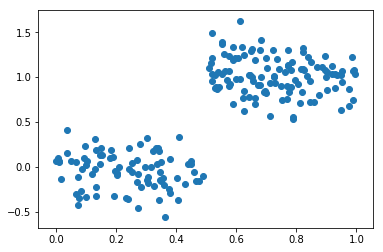

In [275]:
fig00 = plt.figure()
ax00 = fig00.add_subplot(111)
ax00.scatter(myData00[:,0].T.A,myData00[:,1].T.A) 
plt.show()

In [276]:
# 2个叶子节点
createTree(myData00)

{'left': 1.0180967672413792,
 'right': -0.044650285714285719,
 'spInd': 0,
 'spVal': 0.48813}

In [277]:
myData0 = loadDataSet('./ex0.txt')

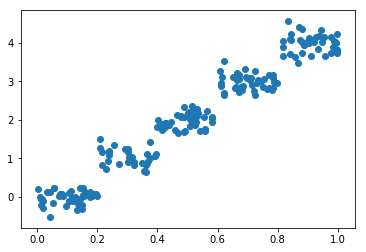

In [278]:
fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
ax0.scatter(myData0[:,1].T.A,myData0[:,2].T.A) 
plt.show()

In [279]:
# 5个叶子节点
createTree(myData0)

{'left': {'left': {'left': 3.9871631999999999,
   'right': 2.9836209534883724,
   'spInd': 1,
   'spVal': 0.797583},
  'right': 1.980035071428571,
  'spInd': 1,
  'spVal': 0.582002},
 'right': {'left': 1.0289583666666666,
  'right': -0.023838155555555553,
  'spInd': 1,
  'spVal': 0.197834},
 'spInd': 1,
 'spVal': 0.39435}

## 后剪枝

In [280]:
myData2 = loadDataSet('./ex2.txt')

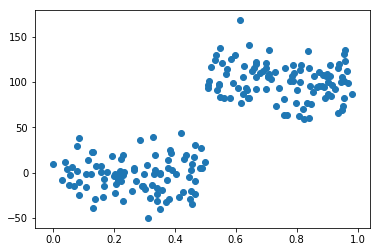

In [281]:
# 从图中可以看出：该数据集label值非常大，是ex00.txt的百倍
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(myData2[:,0].T.A,myData2[:,1].T.A) 
plt.show()

In [282]:
# 树的结构非常依赖opt参数的设置，尤其是tolS，这里为（1,4），基本上为每一个数据设置了叶子节点
# 严重的过拟合
# 需要使用剪枝技术
createTree(myData2)

(5, 2)
(3, 2)
数据集很小
(13, 2)
(1, 2)
数据集很小
(44, 2)
(3, 2)
数据集很小
(1, 2)
(7, 2)
数据集很小
(2, 2)
(10, 2)
数据集很小
(7, 2)
(2, 2)
数据集很小
(17, 2)
(2, 2)
数据集很小
(3, 2)
(6, 2)
数据集很小
(16, 2)
(2, 2)
数据集很小


{'left': {'left': {'left': 108.838789625,
   'right': {'left': {'left': {'left': {'left': 87.310387500000004,
       'right': {'left': {'left': 96.452866999999998,
         'right': 101.33492885714286,
         'spInd': 0,
         'spVal': 0.910975},
        'right': 95.275843166666661,
        'spInd': 0,
        'spVal': 0.85497},
       'spInd': 0,
       'spVal': 0.944221},
      'right': {'left': 81.110151999999999,
       'right': 88.784498800000009,
       'spInd': 0,
       'spVal': 0.811602},
      'spInd': 0,
      'spVal': 0.833026},
     'right': 102.35780185714285,
     'spInd': 0,
     'spVal': 0.790312},
    'right': 78.085643250000004,
    'spInd': 0,
    'spVal': 0.759504},
   'spInd': 0,
   'spVal': 0.952833},
  'right': 107.68699163829788,
  'spInd': 0,
  'spVal': 0.729397},
 'right': {'left': 7.9699461249999999,
  'right': {'left': {'left': {'left': -12.558604833333334,
     'right': 5.7167668333333346,
     'spInd': 0,
     'spVal': 0.437652},
    'right': {'left'

In [176]:
createTree(myData2,ops=(10000,4))

{'left': 101.35815937735848,
 'right': -2.6377193297872341,
 'spInd': 0,
 'spVal': 0.499171}

In [165]:
# 后剪枝技术
# 基于交叉验证，需要将数据分为训练集、测试集
# 原理：合并一棵树的两个叶子节点，然后计算测试集误差，对于能够降低误差的两个叶子节点做塌陷处理
# 说白了就是将测试数据用到二叉树上，查看是否满足剪枝，遇到子节点也是树的，递归调用本身
# 两个剪枝条件：1.该分支没有数据用到，2.在测试集上，分子合并后的误差比不合并的小
# 原因：在建立树的过程中，只考虑了训练集拆分后误差最小，并考虑了训练集拆分前 拆分后误差的情况，
# 但是由于过拟合问题，对于测试集，存在不确定性，需要使用交叉验证进行剪枝
def isTree(obj):
    return (type(obj).__name__ == 'dict')

# 塌陷处理：返回树的平均值
# 只要子树是树不是叶子节点，就调用自己
# 子树两个都是自己叶子节点的，就求两个叶子节点的均值
# 用该均值替代当前的树
def getMean(tree):
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
    return (tree['left']+tree['right'])/2.0

def prune(tree, testData):
    if np.shape(testData)[0] == 1: return getMean(tree) # 第一个剪枝条件：当前树没有被测试集覆盖到，递归求均值
    
    # A B 两个条件是互斥的，但是A条件的操作可能使得B条件达成： 对于A中所有子树，全都剪枝了
    
    # A：只要是任意一个分支有子树，就要先递归地剪枝，递归前需要先拆分数据集
    if (isTree(tree['left']) or isTree(tree['right'])):
        lSet,rSet = binSplitDataSet(testData,tree['spInd'],tree['spVal'])
    if isTree(tree['left']): tree['left'] = prune(tree['left'],lSet) # 递归到最底层，然后逐层向上
    if isTree(tree['right']): tree['right'] = prune(tree['right'],rSet)
    
    # B：当两个分支是叶子节点，才可以进行是否剪枝判断,即使两个分支都是叶子节点也需要进行拆分数据集
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet,rSet = binSplitDataSet(testData,tree['spInd'],tree['spVal'])
        errorNoMerge = np.sum(np.power(lSet[:,-1] - tree['left'], 2)) + np.sum(np.power(rSet[:,-1] - tree['right'], 2)) # 两个分支的方差总和
        treeMean = (tree['left'] + tree['right'])/2
        errorMerge = np.sum(np.power(testData[:,-1] - treeMean, 2)) # 方差总和
        if errorMerge < errorNoMerge:
            print('merging')
            return treeMean
        else:
            return tree # 两分支都是叶子节点，但是不能剪枝
    else:
        return tree # 两分支中存在非叶子节点，不能剪枝

In [169]:
myTree3 = createTree(myData2,ops=(0,1))
myTree3

{'left': {'left': {'left': {'left': {'left': 86.399636999999998,
     'right': 98.648346000000004,
     'spInd': 0,
     'spVal': 0.968621},
    'right': {'left': {'left': {'left': 112.386764,
       'right': 123.559747,
       'spInd': 0,
       'spVal': 0.960398},
      'right': 135.83701300000001,
      'spInd': 0,
      'spVal': 0.958512},
     'right': 104.62626999999999,
     'spInd': 0,
     'spVal': 0.956951},
    'spInd': 0,
    'spVal': 0.965969},
   'right': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': 100.649591,
                'right': 73.520802000000003,
                'spInd': 0,
                'spVal': 0.952377},
               'right': 105.75250800000001,
               'spInd': 0,
               'spVal': 0.949198},
              'right': 69.318648999999994,
              'spInd': 0,
              'spVal': 0.948822},
             'right': {'left': {'left': 110.03503850000001,
               'rig

In [163]:
myData3Test = loadDataSet('ex2test.txt')

In [170]:
# 虽然大量分支被剪掉了，但是还是没能剪到两个分支
# 后剪枝不如预剪枝效果好
# 因此最好把两种剪枝技术都应用
prune(myTree3,myData3Test)

merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging


{'left': {'left': {'left': {'left': 92.523991499999994,
    'right': {'left': {'left': {'left': 112.386764,
       'right': 123.559747,
       'spInd': 0,
       'spVal': 0.960398},
      'right': 135.83701300000001,
      'spInd': 0,
      'spVal': 0.958512},
     'right': 104.62626999999999,
     'spInd': 0,
     'spVal': 0.956951},
    'spInd': 0,
    'spVal': 0.965969},
   'right': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': {'left': 96.41885225,
              'right': 69.318648999999994,
              'spInd': 0,
              'spVal': 0.948822},
             'right': {'left': {'left': 110.03503850000001,
               'right': {'left': 65.548417999999998,
                'right': {'left': 115.75399400000001,
                 'right': {'left': 91.265859999999989,
                  'right': {'left': 112.66407100000001,
                   'right': {'left': 87.300624999999997,
                    'right': {'left': {'left': 100.133819,
  

## 模型树

In [200]:
myData4 = loadDataSet('exp2.txt')

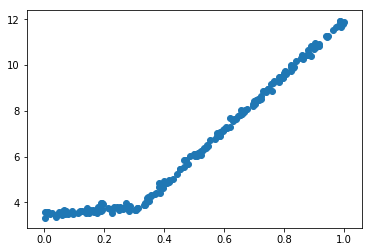

In [187]:
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.scatter(myData4[:,0].T.A,myData4[:,1].T.A) 
plt.show()

In [227]:
# y = 3.5 + 1,0*x
# y = 0 + 12*x
createTree(myData4,leafType = modelLeaf,errType= modelErr,ops = (1,8))

{'left': matrix([[  1.69855694e-03],
         [  1.19647739e+01]]), 'right': matrix([[ 3.46877936],
         [ 1.18521743]]), 'spInd': 0, 'spVal': 0.285477}

## 预测

In [333]:
def regTreeEval(model,inData):
    return model # 常数的分段函数
def modelTreeEval(model,inData):
    n = np.shape(inData)[1]
    X = np.mat(np.ones((1,n+1))) # 因为使用的是测试集，所以没有label列
    X[:,1:n+1] = inData
    return X*model

In [334]:
def treeForeCast(tree,inData,modelEval=regTreeEval):
    if not isTree(tree):return modelEval(tree,inData) # 或者是常数，或者是模型系数
    if inData[tree['spInd']] > tree['spVal']:
        if isTree(tree['left']):
            return treeForeCast(tree['left'],inData,modelEval)
        else:
            return modelEval(tree['left'],inData)
    else:
        if isTree(tree['right']):
            return treeForeCast(tree['right'],inData,modelEval)
        else:
            return modelEval(tree['right'],inData)

In [335]:
def createForeCast(tree,testData,modelEval = regTreeEval):
    m = len(testData)
    yHat = np.mat(np.zeros((m,1)))
    for i in range(m):
        yHat[i,0] = treeForeCast(tree,np.mat(testData[i]),modelEval)
    return yHat

In [232]:
trainMat = loadDataSet('bikeSpeedVsIq_train.txt')
testMat = loadDataSet('bikeSpeedVsIq_test.txt')

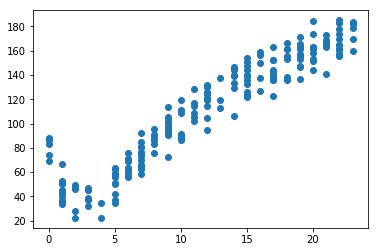

In [233]:
fig5 = plt.figure()
ax5 = fig5.add_subplot(111)
ax5.scatter(trainMat[:,0].T.A,trainMat[:,1].T.A) 
plt.show()

In [352]:
myTreeBike =createTree(trainMat,ops=(1,20))
yHat = createForeCast(myTreeBike,testMat[:,0])
np.corrcoef(yHat,testMat[:,1],rowvar = 0)[0,1]

0.96408523182221495

In [353]:
myTreeBike =createTree(trainMat,ops=(1,10))
yHat = createForeCast(myTreeBike,testMat[:,0])
np.corrcoef(yHat,testMat[:,1],rowvar = 0)[0,1]

0.97243264682678021

In [354]:
myTreeBike =createTree(trainMat,ops=(1,6))
yHat = createForeCast(myTreeBike,testMat[:,0])
np.corrcoef(yHat,testMat[:,1],rowvar = 0)[0,1]

0.97853793369246755

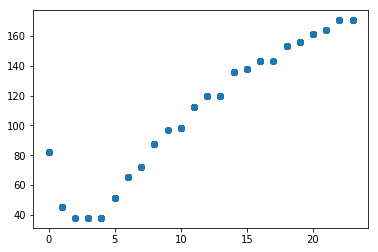

In [350]:
fig6 = plt.figure()
ax6 = fig6.add_subplot(111)
ax6.scatter(testMat[:,0].T.A,yHat.T.A) 
plt.show()

In [355]:
myTreeBike2 =createTree(trainMat,leafType=modelLeaf,errType=modelErr,ops=(1,20))
yHat2 = createForeCast(myTreeBike2,testMat[:,0],modelEval= modelTreeEval)
np.corrcoef(yHat2,testMat[:,1],rowvar = 0)[0,1]

0.97604121913806285

In [359]:
myTreeBike2 =createTree(trainMat,leafType=modelLeaf,errType=modelErr,ops=(1,17)) # ops = （1,17） 保证逆矩阵存在的最小值
yHat2 = createForeCast(myTreeBike2,testMat[:,0],modelEval= modelTreeEval)
np.corrcoef(yHat2,testMat[:,1],rowvar = 0)[0,1]

0.9783086799216234

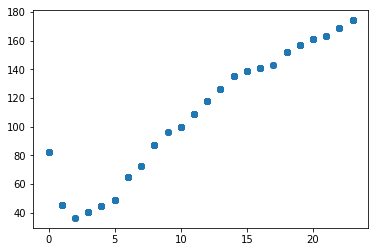

In [360]:
fig7 = plt.figure()
ax7 = fig7.add_subplot(111)
ax7.scatter(testMat[:,0].T.A,yHat2.T.A) 
plt.show()

In [2]:
import tkinter as tk

In [3]:
root = tk.Tk()
mylabel = tk.Label(root,text='first')
mylabel.grid()
root.mainloop()